In [8]:
import os
import random
import warnings

import matplotlib.pyplot as plt
import simplstyles
import numpy as np
import pandas as pd
import seaborn as sns
from himalaya.backend import set_backend

from compare_variance_residual.residual import residual_method
from compare_variance_residual.simulation import generate_dataset
from compare_variance_residual.variance_partitioning import variance_partitioning

In [9]:
def get_path(alphas, cv, n_targets):
    path = os.path.join("results", f"targets={n_targets}", f"cv={cv}",
                        f"alphas={alphas.min()},{alphas.max()},{len(alphas)}", "varying training samples")
    os.makedirs(path, exist_ok=True)
    return path

In [10]:
def save_scores(samples_train, d_list, scalars, n_targets, n_samples_test, noise_target, cv, alphas):
    path = get_path(alphas, cv, n_targets)
    for n_samples_train in samples_train:
        print(n_samples_train)
        csv_path = os.path.join(path, f"scores_{n_samples_train}.csv")
        scores = pd.DataFrame()
        if os.path.exists(csv_path):
            print("skipping, already exists")
            continue
        Xs, Y = generate_dataset(d_list, scalars, n_targets, n_samples_train + n_samples_test, noise_target)
        print("data generated")
        x1_score, x2_score, joint_score, x1_and_x2_score, vp_x1_unique_score, vp_x2_unique_score = variance_partitioning(
            Xs, Y, n_samples_train, alphas, cv)
        print("variance partitioning done")

        scores["x1_score"] = x1_score
        scores["x2_score"] = x2_score
        scores["vp_joint_score"] = joint_score
        scores["vp_shared_score"] = x1_and_x2_score
        scores["vp_x1_unique_score"] = vp_x1_unique_score
        scores["vp_x2_unique_score"] = vp_x2_unique_score
        del x1_score, x2_score, joint_score, x1_and_x2_score, vp_x1_unique_score, vp_x2_unique_score

        _, _, x2_to_x1_score, x1_to_x2_score, rm_x1_unique_score, rm_x2_unique_score = residual_method(
            Xs, Y, n_samples_train, alphas, cv)
        print("residual method done")
        scores["rm_x2_to_x1_score"] = np.concatenate(
            [x2_to_x1_score, np.full(len(rm_x1_unique_score) - len(x2_to_x1_score), np.nan)])
        scores["rm_x1_to_x2_score"] = np.concatenate(
            [x1_to_x2_score, np.full(len(rm_x1_unique_score) - len(x1_to_x2_score), np.nan)])
        scores["rm_x1_unique_score"] = rm_x1_unique_score
        scores["rm_x2_unique_score"] = rm_x2_unique_score
        print(scores.head())
        del x2_to_x1_score, x1_to_x2_score, rm_x1_unique_score, rm_x2_unique_score
        del Xs, Y
        scores.to_csv(csv_path, index=False)

# Save scores for varying training samples

In [11]:
backend = set_backend("cupy", on_error="warn")
warnings.filterwarnings("ignore")
random.seed(42)
plt.style.use('nord-light-talk')

In [12]:
d_list = [100, 100, 100]
n_targets = 10000
n_samples_test = 100
scalars = [1 / 3, 1 / 3, 1 / 3]
noise_target = 0.1

cv = 10
alphas = np.logspace(-5, 5, 10)

In [13]:
samples_train = np.logspace(3, 4.47712125472, 5).astype(int)

In [ ]:
save_scores(samples_train, d_list, scalars, n_targets, n_samples_test, noise_target, cv, alphas)

1000
skipping, already exists
2340
data generated


# Load scores

In [41]:
vp = pd.DataFrame()
rm = pd.DataFrame()

for i, n_samples_train in enumerate(samples_train):
    scores = pd.read_csv(os.path.join(get_path(alphas, cv, n_targets), f"scores_{n_samples_train}.csv"))
    vp_x1_unique_predicted = scores['vp_x1_unique_score']
    vp_x1_se = (vp_x1_unique_predicted - scalars[1]).std()
    vp_scores = pd.DataFrame({
        'n_samples_train': n_samples_train,
        'vp_joint_score': scores['vp_joint_score'].mean(),
        'vp_x1_unique_score': vp_x1_unique_predicted.mean(),
        'vp_x1_se': vp_x1_se,
        'vp_x1_lower_se': vp_x1_unique_predicted.mean() - vp_x1_se,
        'vp_x1_upper_se': vp_x1_unique_predicted.mean() + vp_x1_se
    }, index=[i])

    rm_x1_unique_score = scores['rm_x1_unique_score']
    rm_x1_se = (rm_x1_unique_score - scalars[1]).std()
    rm_scores = pd.DataFrame({
        'n_samples_train': n_samples_train,
        'rm_x1_unique_score': rm_x1_unique_score.mean(),
        'rm_x1_se': rm_x1_se,
        'rm_x1_lower_se': rm_x1_unique_score.mean() - rm_x1_se,
        'rm_x1_upper_se': rm_x1_unique_score.mean() + rm_x1_se
    }, index=[i])

    vp = pd.concat([vp, vp_scores], ignore_index=True)
    rm = pd.concat([rm, rm_scores], ignore_index=True)
vp.head()
rm.head()

,n_samples_train,rm_x1_unique_score,rm_x1_se,rm_x1_lower_se,rm_x1_upper_se
0,1000,0.097668,0.122676,-0.025008,0.220344
1,2154,0.209612,0.098971,0.110641,0.308583
2,4641,0.258930,0.087461,0.171470,0.346391
3,10000,0.273974,0.082804,0.191169,0.356778


Text(0, 0.5, 'Predicted Unique Variance (avg. $R^2$)')

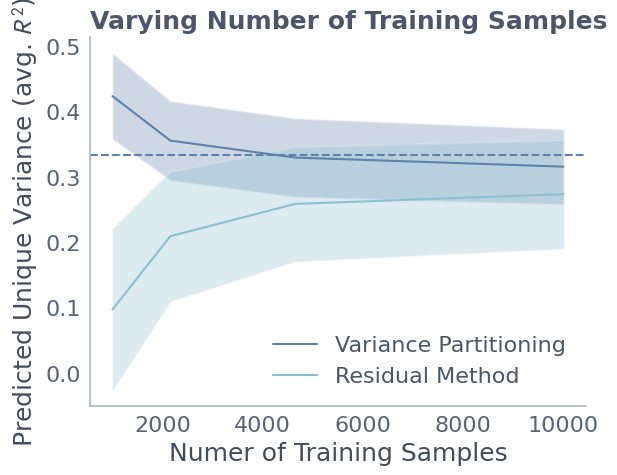

In [43]:
hue_order = ['Residual Method', 'Variance Partitioning', ]
sns.lineplot(data=vp, x='n_samples_train', y='vp_x1_unique_score', label='Variance Partitioning', palette='C2')
plt.fill_between(vp['n_samples_train'], vp['vp_x1_lower_se'], vp['vp_x1_upper_se'], alpha=0.3)
sns.lineplot(data=rm, x='n_samples_train', y='rm_x1_unique_score', label='Residual Method', hue_order=hue_order)
plt.fill_between(rm['n_samples_train'], rm['rm_x1_lower_se'], rm['rm_x1_upper_se'], alpha=0.3)
plt.axhline(scalars[1], linestyle='--', label='true unique variance')
plt.title(r"Varying Number of Training Samples")
plt.xlabel(r"Numer of Training Samples")
plt.ylabel(r"Predicted Unique Variance (avg. $R^2$)")